In [33]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
from foolbox import TensorFlowModel
from foolbox.attacks import FGSM

import random

In [10]:
x_real = np.load('dataset/x_real.npz')['data']
y_real = np.load('dataset/y_real.npy')
x_easy = np.load('dataset/x_easy.npz')['data']
y_easy = np.load('dataset/y_easy.npy')
x_medium = np.load('dataset/x_medium.npz')['data']
y_medium = np.load('dataset/y_medium.npy')
x_hard = np.load('dataset/x_hard.npz')['data']
y_hard = np.load('dataset/y_hard.npy')

In [11]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)

In [12]:
augs = [x_data[40000]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

In [13]:
label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i

In [14]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index * self.batch_size:(index + 1) * self.batch_size]
        label_batch = self.label[index * self.batch_size:(index + 1) * self.batch_size]

        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)

        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)

        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [15]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

In [16]:
x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))

# share weights both inputs
inputs = layers.Input(shape=(90, 90, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 22, 22, 32)   9568        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 subtract (Subtract)            (None, 22, 22, 32)   0           ['model[0][0]',            

In [17]:
history = model.fit_generator(train_gen, epochs=10, validation_data=val_gen)

C:\Users\eugen\AppData\Local\Temp/ipykernel_17144/352558745.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=10, validation_data=val_gen)


Epoch 1/10
1385/1385 [==============================] - 510s 367ms/step - loss: 0.2342 - acc: 0.8978 - val_loss: 0.0874 - val_acc: 0.9616
Epoch 2/10
1385/1385 [==============================] - 533s 385ms/step - loss: 0.1347 - acc: 0.9485 - val_loss: 0.0881 - val_acc: 0.9679
Epoch 3/10
1385/1385 [==============================] - 520s 376ms/step - loss: 0.1092 - acc: 0.9591 - val_loss: 0.0203 - val_acc: 0.9910
Epoch 4/10
1385/1385 [==============================] - 522s 377ms/step - loss: 0.0910 - acc: 0.9651 - val_loss: 0.0239 - val_acc: 0.9902
Epoch 5/10
1385/1385 [==============================] - 526s 380ms/step - loss: 0.0843 - acc: 0.9687 - val_loss: 0.0207 - val_acc: 0.9914
Epoch 6/10
1385/1385 [==============================] - 514s 371ms/step - loss: 0.0754 - acc: 0.9726 - val_loss: 0.0107 - val_acc: 0.9955
Epoch 7/10
1385/1385 [==============================] - 502s 362ms/step - loss: 0.0683 - acc: 0.9755 - val_loss: 0.0144 - val_acc: 0.9937
Epoch 8/10
1385/1385 [============

1/1 [==============================] - 0s 38ms/step


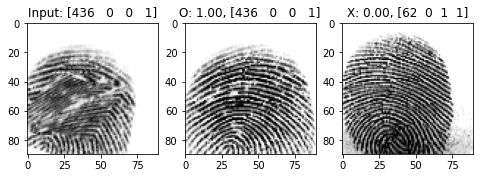

In [18]:
# new user fingerprint input
random_idx = random.randint(0, len(x_val))

random_img = x_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
uy = y_real[unmatch_idx]

pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' % random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(ux.squeeze(), cmap='gray')

In [19]:
model.predict()

In [32]:
model.predict(val_gen[0][0])

1/1 [==============================] - 0s 112ms/step


array([[9.99999762e-01],
       [9.99788523e-01],
       [1.12338335e-29],
       [9.99999881e-01],
       [5.37754362e-23],
       [1.11520683e-06],
       [2.42601206e-09],
       [9.99999940e-01],
       [6.67226340e-18],
       [9.99997675e-01],
       [3.72761126e-18],
       [6.93523879e-14],
       [6.12400484e-14],
       [0.00000000e+00],
       [9.45618153e-01],
       [9.99999821e-01],
       [1.35084777e-36],
       [1.04312876e-23],
       [2.34955610e-06],
       [9.88371551e-01],
       [9.99628603e-01],
       [9.99913931e-01],
       [9.99355316e-01],
       [1.19605028e-28],
       [4.33521018e-05],
       [9.99999940e-01],
       [9.99986291e-01],
       [9.99735951e-01],
       [8.41805729e-07],
       [9.99998569e-01],
       [0.00000000e+00],
       [1.17566561e-08]], dtype=float32)

In [42]:
attack = FGSM()
fmodel = TensorFlowModel(model, bounds=(0, 1))
raw, clipped, is_adv = attack(fmodel, np.array(val_gen[0][0]), val_gen[0][1], epsilons=3)

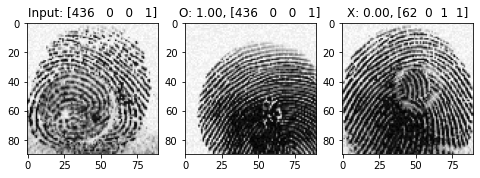

In [70]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' % random_label)
plt.imshow(val_gen[0][0][0][1].squeeze() - np.random.rand(90, 90) * 0.1, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(val_gen[0][0][1][1].squeeze() - np.random.rand(90, 90) * 0.1, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(val_gen[0][0][0][2].squeeze() - np.random.rand(90, 90) * 0.1, cmap='gray')

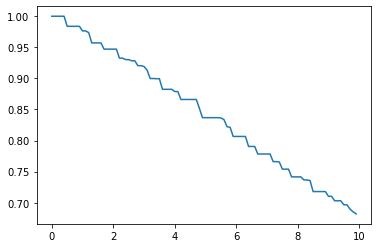

In [67]:
from sklearn.metrics import accuracy_score

history = []
for eps in range(1, 100):
    attack = FGSM()
    fmodel = TensorFlowModel(model, bounds=(0, 1))
    raw, clipped, is_adv = attack(fmodel, np.array(val_gen[0][0]), val_gen[0][1], epsilons=eps / 10)
    history.append(accuracy_score(val_gen[0][1], fmodel(clipped).argmax(axis=1)))

"plt.subplot(1, 3, 3)\nplt.title('X: %.02f, %s' % (pred_ux, uy))\nplt.imshow(val_gen[1][0][0][0].squeeze() - np.random.rand(90, 90) * 0., cmap='gray')"

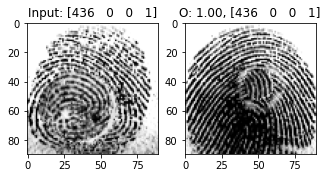

In [76]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' % random_label)
plt.imshow(val_gen[0][0][0][1].squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(val_gen[0][0][0][2].squeeze(), cmap='gray')
"""plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(val_gen[1][0][0][0].squeeze() - np.random.rand(90, 90) * 0., cmap='gray')"""

In [53]:
model.predict(val_gen[0][0])

1/1 [==============================] - 0s 120ms/step


array([[9.9999976e-01],
       [5.7982353e-14],
       [1.5048446e-26],
       [9.9999988e-01],
       [2.5621715e-26],
       [1.2799621e-14],
       [5.7910674e-04],
       [1.2546222e-07],
       [7.9369138e-17],
       [1.3066691e-18],
       [8.1344298e-26],
       [4.9778226e-10],
       [9.9608898e-01],
       [1.0000000e+00],
       [9.4561815e-01],
       [2.5213592e-07],
       [9.9999994e-01],
       [2.4549672e-06],
       [7.5568572e-11],
       [1.2754521e-09],
       [9.3824689e-05],
       [9.6960919e-04],
       [9.9935532e-01],
       [9.9999988e-01],
       [9.9986470e-01],
       [5.0590639e-15],
       [2.1828967e-01],
       [5.0814835e-14],
       [9.9998897e-01],
       [4.6564162e-15],
       [0.0000000e+00],
       [3.7728187e-02]], dtype=float32)

In [100]:
from source import decompress, compress, gaussian

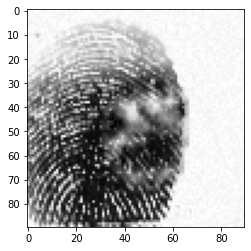

In [93]:
plt.imshow(val_gen[0][0][0][0].reshape(90, 90) + np.random.rand(90, 90) * 0.04, cmap="gray")

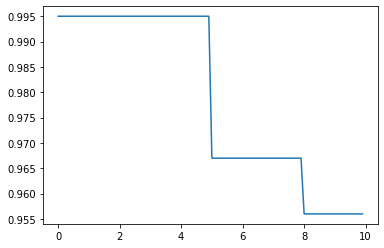

In [95]:
history = []
for eps in range(1, 100):
    attack = FGSM()
    fmodel = TensorFlowModel(model, bounds=(0, 1))
    raw, clipped, is_adv = attack(fmodel, np.array([compress(gaussian(decompress(i))) for i in val_gen[0][0]]),
                                  val_gen[0][1], epsilons=eps / 10)
    history.append(accuracy_score(val_gen[0][1], fmodel(clipped).argmax(axis=1)))

In [99]:
(0.995 - 0.956) * 1000 / 10

3.9000000000000035